In [2]:
from scipy.stats import ttest_ind
import helper 
import xarray as xr 
import numpy as np 
import cmaps as cmap 
import matplotlib.pyplot as plt
import scipy 
import warnings
import matplotlib.patheffects as pe
from matplotlib.colors import Normalize
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import matplotlib.patheffects as pe
warnings.filterwarnings("ignore")

dataset1 = r"C:\Users\deela\Downloads\tc_radar_v3m_1997_2019_xy_rel_swath_ships.nc"
dataset2 = r"C:\Users\deela\Downloads\tc_radar_v3m_2020_2024_xy_rel_swath_ships.nc"
dataset = xr.open_mfdataset([dataset1,dataset2], concat_dim='num_cases', combine='nested')

In [3]:
print(dataset, list(dataset.variables))

<xarray.Dataset> Size: 316GB
Dimensions:                                         (num_cases: 1510,
                                                     latitude: 200,
                                                     longitude: 200,
                                                     northward_distance: 201,
                                                     eastward_distance: 201,
                                                     height: 37,
                                                     ships_lag_times: 17)
Coordinates:
  * num_cases                                       (num_cases) float32 6kB 0...
  * height                                          (height) float32 148B 0.0...
  * ships_lag_times                                 (ships_lag_times) float32 68B ...
  * eastward_distance                               (eastward_distance) float32 804B ...
  * northward_distance                              (northward_distance) float32 804B ...
Dimensions without coordinates

In [42]:
data = dataset['swath_wind_speed']
print(data, data.values.shape)

<xarray.DataArray 'swath_wind_speed' (num_cases: 1510, latitude: 200,
                                      longitude: 200, height: 37)> Size: 9GB
dask.array<concatenate, shape=(1510, 200, 200, 37), dtype=float32, chunksize=(134, 34, 34, 5), chunktype=numpy.ndarray>
Coordinates:
  * num_cases  (num_cases) float32 6kB 0.0 1.0 2.0 3.0 ... 797.0 798.0 799.0
  * height     (height) float32 148B 0.0 0.5 1.0 1.5 2.0 ... 16.5 17.0 17.5 18.0
Dimensions without coordinates: latitude, longitude
Attributes:
    units:      m s**-1
    long_name:  storm-relative horizontal wind speed in the original analysis... (1510, 200, 200, 37)


In [43]:
v500 = data.sel(height=.5).values
profs = data.values.reshape(1510, 200 * 200, 37)

ValueError: All-NaN slice encountered

In [52]:
print(v500.shape, profs.shape)
vflat = v500.reshape(1510, -1)
bad = np.isnan(vflat).all(axis=1)
vflat[bad] = -np.inf
maxLocs = np.nanargmax(vflat, axis=1)
maxProfs = profs[np.arange(1510), maxLocs] * 1.94384
print(maxProfs.shape)

(1510, 200, 200) (1510, 40000, 37)
(1510, 37)


0.97379524


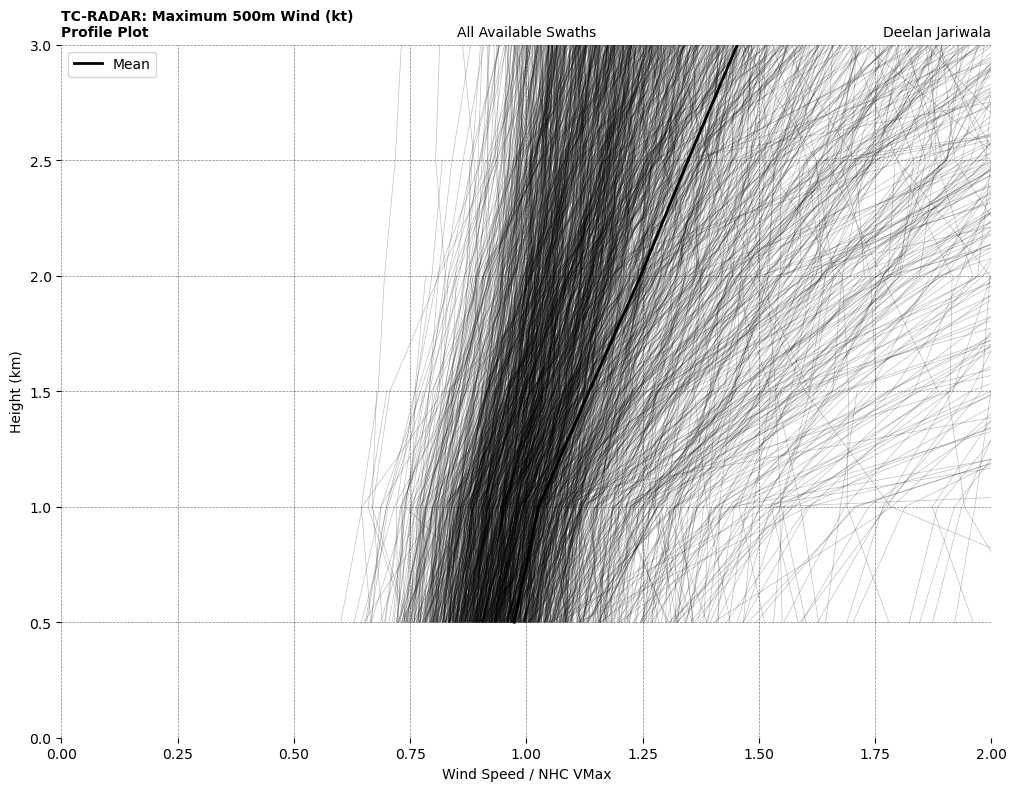

In [265]:
from matplotlib.colors import LogNorm, PowerNorm
from scipy.ndimage import gaussian_filter 
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

fig = plt.figure(figsize = (12, 9))
ax = plt.axes()
ax.set_frame_on(False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_xlabel('Wind Speed / NHC VMax')
ax.set_ylabel('Height (km)')
ax.set_ylim(0, 3)
ax.set_xlim(0, 2)

height = data.height
vmax = dataset['vmax_ships'].sel(ships_lag_times = 0).values
rmw = dataset['tc_rmw'].sel(height = 0.5).values
temp = vmax[:, None] / maxProfs
print(np.nanmean(temp, axis = 0)[1])

segments = np.stack([temp, np.tile(height, (temp.shape[0],1))], axis=-1)

# c = LineCollection(segments, cmap= cmap.sshws(), array=rmw, linewidth=0.25, alpha = 1, norm = Normalize(vmin = 0, vmax = 140))

# ax.add_collection(c)

plt.plot(temp.T, data.height, linewidth = 0.5, color = 'black', alpha = 0.25)
# plt.plot(np.nanpercentile(temp, 95, axis = 0), height, linewidth = 2, color = 'red', label = '95th Percentile')
plt.plot(np.nanmean(temp, axis = 0), height, linewidth = 2, color = 'black', label = 'Mean')

ax.legend()

ax.set_title(f'TC-RADAR: Maximum 500m Wind (kt)\nProfile Plot', fontweight='bold', fontsize=10, loc='left')
ax.set_title(f'All Available Swaths', fontsize = 10, loc = 'center')
ax.set_title('Deelan Jariwala', fontsize=10, loc='right') 

# cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02, label = 'Count')
plt.savefig(r"C:\Users\deela\Downloads\maxWindProf3.png", dpi = 200, bbox_inches = 'tight')    
plt.show() 

In [113]:
print(temp.shape)

(1510, 37)


In [155]:
heights = data.height.values
binEdges = np.arange(0, 2.01, 0.01)

bins = [[0 for _ in range(len(binEdges))] for _ in heights]
cnts = [[0 for _ in range(len(binEdges))] for _ in heights]

for i in range(len(heights)):
    t = temp[:, i]
    for j in range(len(binEdges)):
        for k in range(len(t)):
            try:
                if binEdges[j] < t[k] < binEdges[j+1]:
                    bins[i][j] += rmw[k]
                    cnts[i][j] += 1
            except:
                pass

print(np.array(bins).shape, np.array(cnts).shape)
bins = np.array(bins) / np.array(cnts)

(37, 201) (37, 201)


(37, 201) (37, 201) (37, 201)


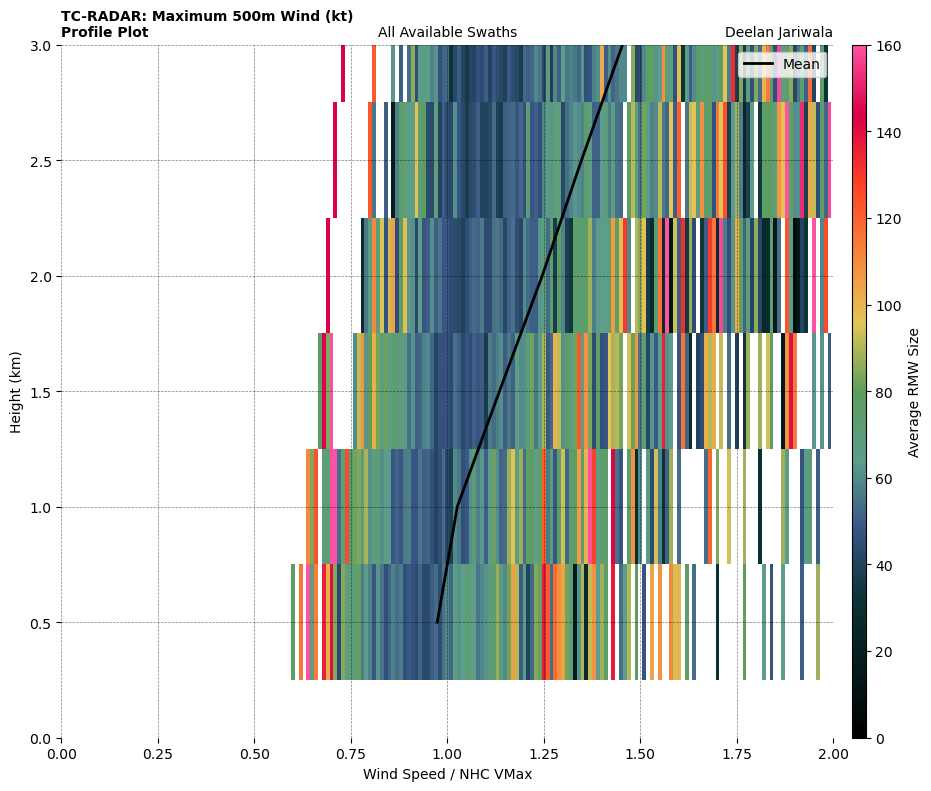

In [156]:
from matplotlib.colors import LogNorm, PowerNorm
from scipy.ndimage import gaussian_filter 
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

fig = plt.figure(figsize = (12, 9))
ax = plt.axes()
ax.set_frame_on(False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_xlabel('Wind Speed / NHC VMax')
ax.set_ylabel('Height (km)')
ax.set_ylim(0, 3)
ax.set_xlim(0, 2)

b, h = np.meshgrid(binEdges, height)#, indexing = 'ij')
print(b.shape, h.shape, bins.shape)

c = plt.pcolormesh(b, h, bins, cmap = cmap.probs4(), vmin = 0, vmax = 160, shading='auto')
plt.plot(np.nanmean(temp, axis = 0), height, linewidth = 2, color = 'black', label = 'Mean')

ax.legend()

ax.set_title(f'TC-RADAR: Maximum 500m Wind (kt)\nProfile Plot', fontweight='bold', fontsize=10, loc='left')
ax.set_title(f'All Available Swaths', fontsize = 10, loc = 'center')
ax.set_title('Deelan Jariwala', fontsize=10, loc='right') 

cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02, label = 'Average RMW Size')
plt.savefig(r"C:\Users\deela\Downloads\maxWindProf4.png", dpi = 200, bbox_inches = 'tight')    
plt.show() 

(1342, 4) (1342,)
1342 (1342,)
[[0.83221227]]
18.42271 172.02736


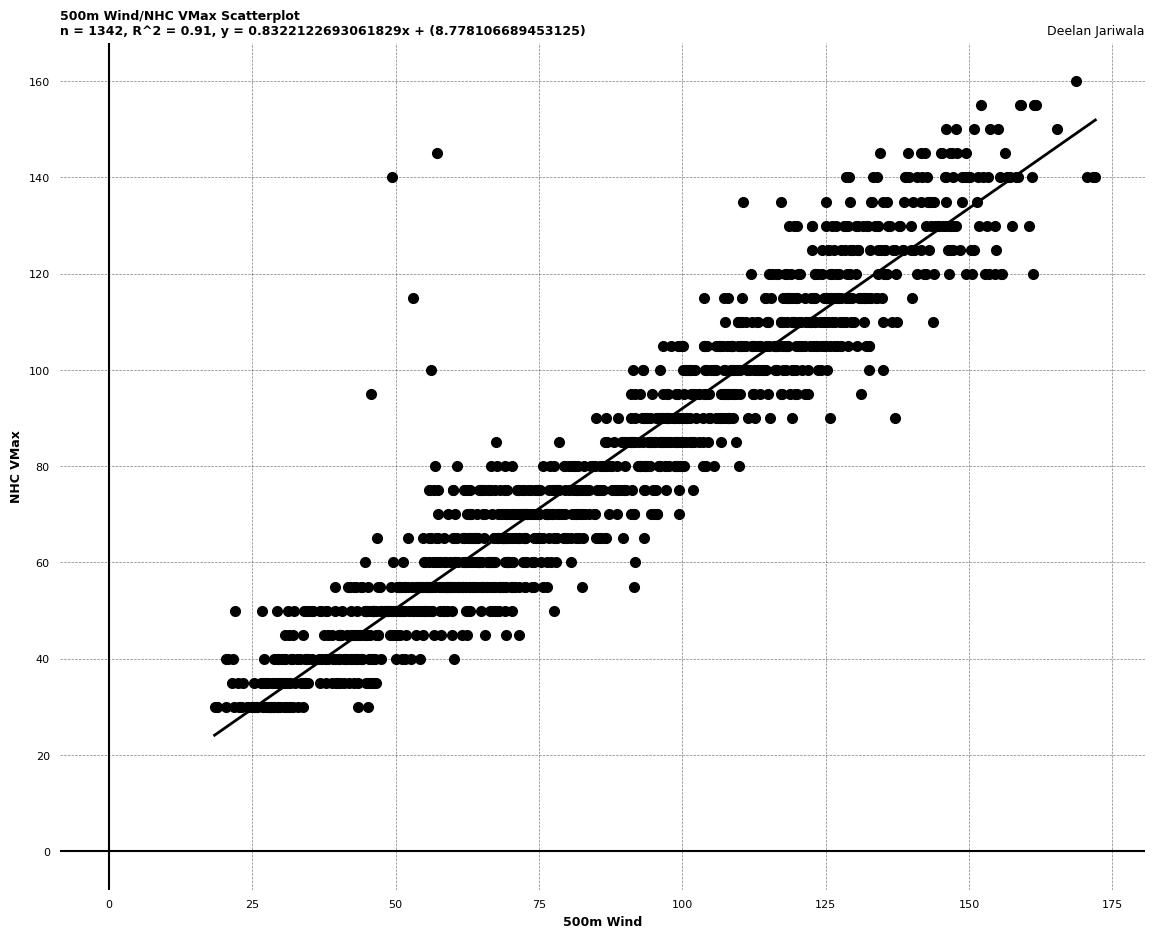

1342 (1342,)
[[-0.44201797]]
8.0 176.0


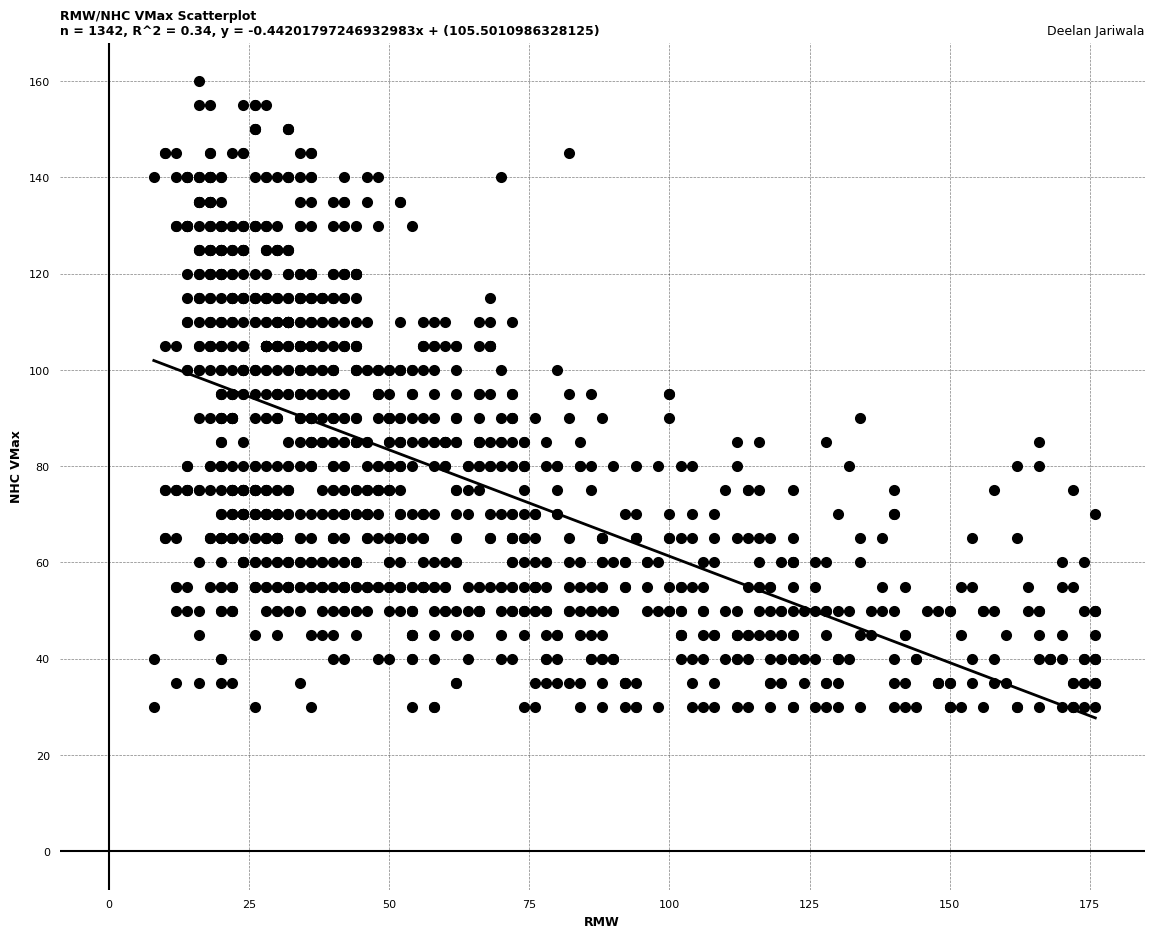

1342 (1342,)
[[0.8959449]]
2.7916286 152.9315


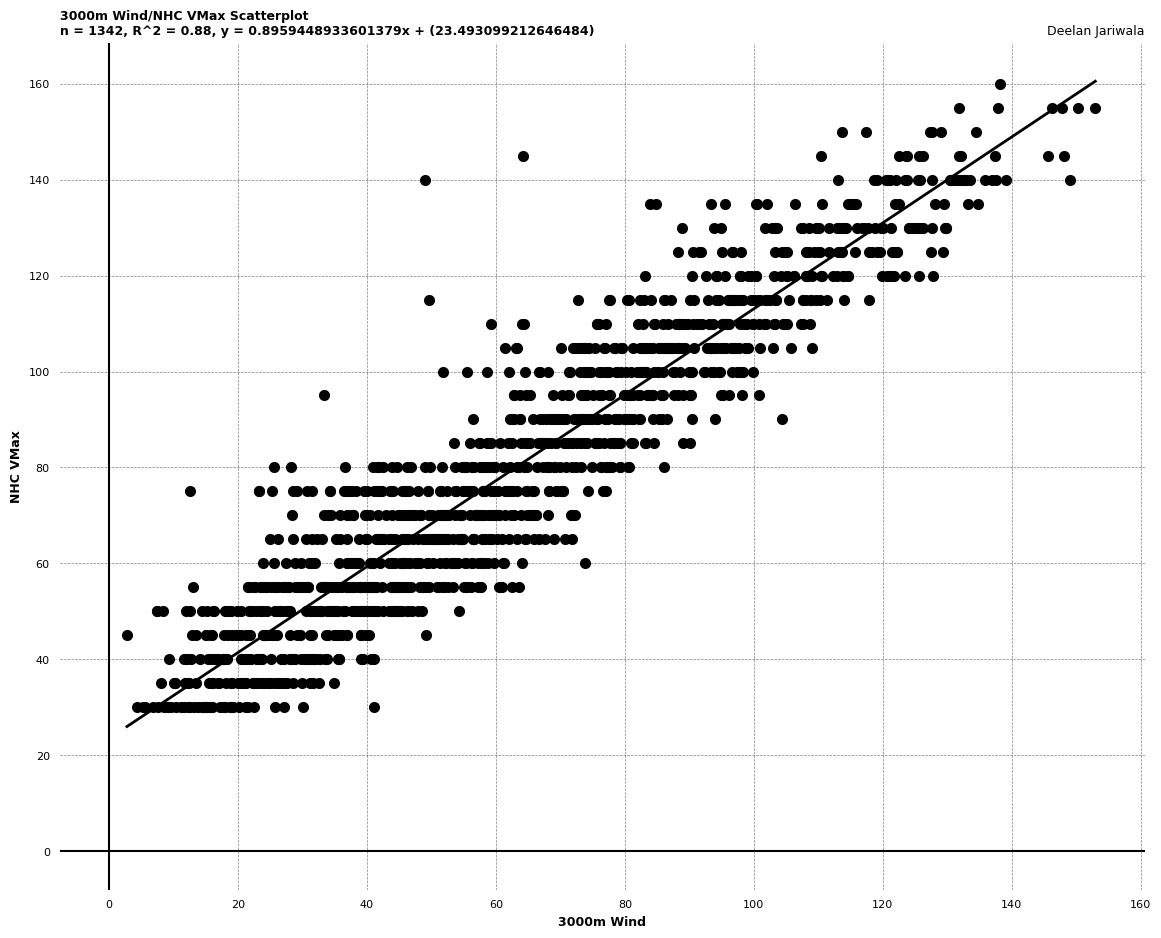

1342 (1342,)
[[0.9531238]]
30.0 160.0


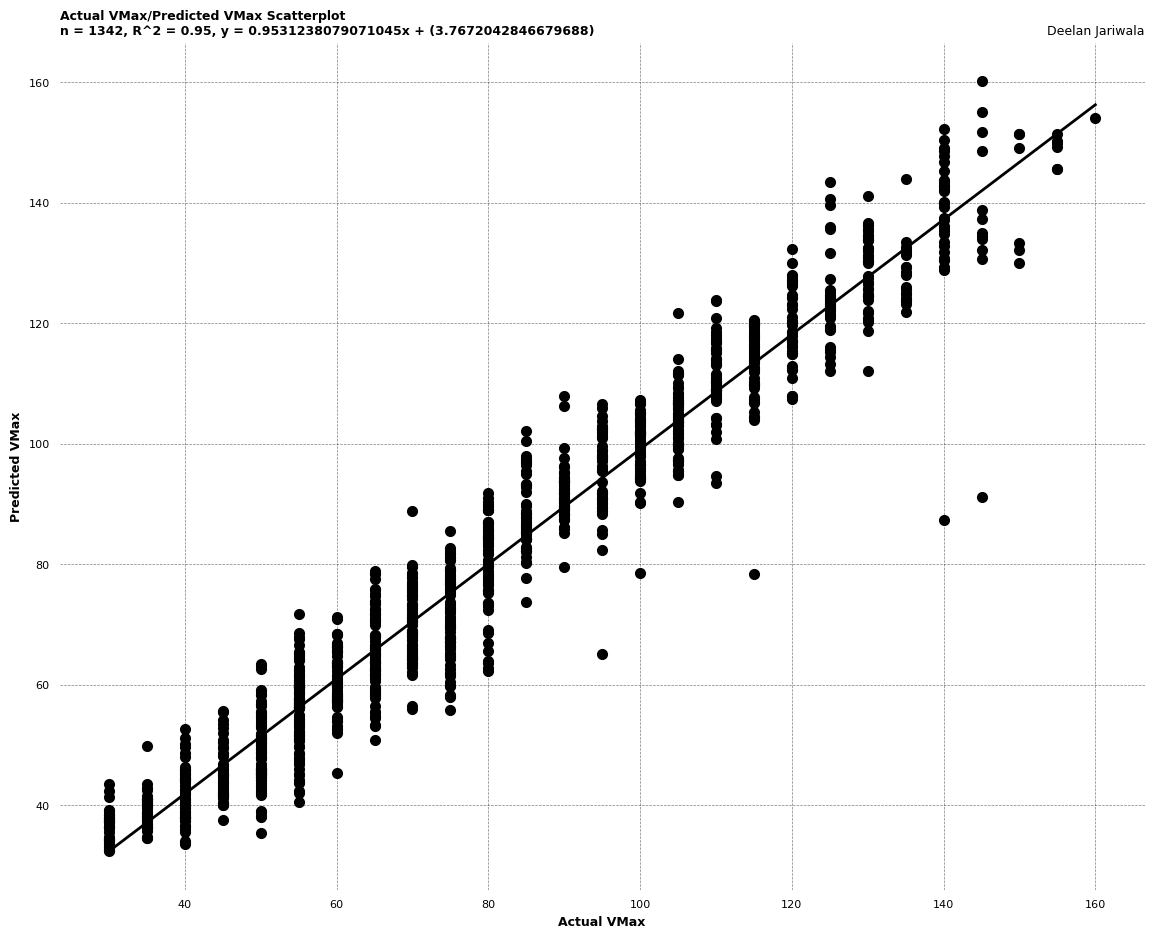

[-6.652008   -5.8685455  -5.6084747  ...  2.6827545   0.5782471
 -0.40524292]
5.0623465kt error
Correlation: 0.9531241059303284






In [269]:
ratio500 = temp[:, 1]
wind500 = maxProfs[:, 1]
wind3km = maxProfs[:, 6]
prs = dataset['pres_ships'].sel(ships_lag_times = 0).values

from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import scipy 
from defaultPlots import scatter
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def regression(input, output, RF = False, GB = False, poly = False): 
    trainIn = input
    trainOut = output
    testIn = input
    testOut = output
   
    if RF == True:
        regr = RandomForestRegressor(n_estimators=200, n_jobs=-1)#, max_features = 0.75, max_depth = 25)
        regr.fit(trainIn, trainOut) 
        predictTest = regr.predict(testIn)
    elif GB == True:
        regr = XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='reg:squarederror',
            random_state=42
        )
        regr.fit(trainIn, trainOut)
        predictTest = regr.predict(testIn)
    elif poly == True:
        regr = make_pipeline(
            PolynomialFeatures(degree=2, include_bias=False),
            LinearRegression()
        )
        regr.fit(trainIn, trainOut)
        predictTest = regr.predict(testIn)
    else:
        regr = linear_model.LinearRegression()
        regr.fit(trainIn, trainOut)
        predictTest = regr.predict(testIn)

    try:
        importance = regr.feature_importances_
    except:
        try:
            coef = np.abs(regr.coef_ * np.nanstd(input, axis = 0))
            importance = coef / np.sum(coef)
        except:
            importance = None
            pass 

    corr, sig = scipy.stats.pearsonr(predictTest, testOut)
    # error = np.sqrt(np.mean((predictTest - testOut)**2))
    error = np.mean(np.abs(predictTest - testOut))
    # scatter(['sqrt((POCI - CKZ) x (RMW divided by ROCI))', testIn[:, 4]], ['VMax (kt)', testIn[:, 0]])
    scatter(['500m Wind', testIn[:, 0]], ['NHC VMax', testOut])
    scatter(['RMW', testIn[:, 1]], ['NHC VMax', testOut])
    scatter(['3000m Wind', testIn[:, 2]], ['NHC VMax', testOut])
    scatter(['Actual VMax', testOut], ['Predicted VMax', predictTest], hline = False, vline = False)

    print(testOut - predictTest)

    print(str(error) + f"kt error\nCorrelation: {corr**2}")

    return regr, predictTest, importance, testIn, testOut

xNames = ['500m Wind', '500m RMW', '3km Wind', 'Pressure']
x = [wind500, rmw, wind3km, prs]
y = vmax

# Start with a mask of all True
mask = ~np.isnan(y) & ~np.isinf(y)

# Update the mask based on each predictor
for i in range(len(x)):
    mask = mask & ~np.isnan(x[i]) & ~np.isinf(x[i])

# Apply the final mask to each predictor
for i in range(len(x)):
    x[i] = x[i][mask]

# Apply the mask to the target
y = y[mask]

# Stack predictors into 2D array and regress
x = np.column_stack(x)
print(x.shape, y.shape)

regr, predictions, feat, testIn, testOut = regression(x, y, poly = True)
print('\n')
try:
    feat = dict(zip(xNames, feat))
    for key, value in feat.items():
        print(f"Feature: {key:>35}, Importance: {value}")
except:
    pass
print('\n')

# for x in range(len(year)):
#     print(year[x], testOut[x], predictions[x], (testOut[x] - predictions[x]))


In [271]:
print(regr.predict(np.array([172, 36, 143.3, 941]).reshape(1, -1)))
print(regr.predict(np.array([175, 15, 159.4, 892]).reshape(1, -1)))

[135.4803471]
[171.23871235]


In [264]:
print(wind.shape)

names = dataset['storm_name'].values
years = dataset['beg_swath_year'].values
maxWinds = np.column_stack([wind * 1.94384, names, years]).astype(object)
print(maxWinds.shape)

(1510,)
(1510, 3)


In [39]:
maxWinds = maxWinds[np.argsort(maxWinds[:, 0].astype(float))]
for x in range(len(maxWinds)):
    print(maxWinds[x])

['12.56903' 'FRED' '2021']
['16.452011' 'FRED' '2021']
['18.42271' 'PTC02' '2019']
['18.848017' 'INVEST' '2020']
['18.881876' 'PTC02' '2019']
['19.588638' 'FRED' '2021']
['20.404894' 'LAURA' '2020']
['20.45251' 'FRED' '2021']
['20.819653' 'LAURA' '2020']
['21.520977' 'DEBBY' '2024']
['21.670433' 'LAURA' '2020']
['21.838123' 'CYCLONE' '2020']
['21.908695' 'ELSA' '2021']
['22.322105' 'INVEST' '2016']
['22.527973' 'ERNESTO' '2024']
['22.637577' 'INVEST' '2016']
['22.980474' 'FRED' '2021']
['23.045767' '0504A' '2014']
['23.430105' 'FRANKLIN' '2023']
['23.624395' 'FRED' '2021']
['24.102112' 'CYCLONE' '2020']
['24.317297' 'FRED' '2021']
['24.92166' 'INVEST' '2024']
['25.001722' 'INVEST' '2024']
['25.109297' 'INVEST' '2016']
['25.216228' 'FRANKLIN' '2023']
['25.263807' 'INVEST' '2024']
['25.596264' 'ETA' '2020']
['25.880215' 'CYCLONE' '2016']
['25.89342' 'PTC02' '2019']
['26.47384' 'CYCLONE' '2020']
['26.500038' 'INVEST' '2020']
['26.67701' 'FRANKLIN' '2023']
['26.68374' 'DORIAN' '2019']
['26

In [4]:
print(data.longitude)

<xarray.DataArray 'longitude' (longitude: 200)> Size: 2kB
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 1

In [5]:
x = data.longitude.values * 2
xCenter = np.nanmean(x)
y = data.latitude.values * 2
yCenter = np.nanmean(y)

X, Y = np.meshgrid(x, y, indexing = 'ij')
r = np.sqrt((X - xCenter)**2 + (Y - yCenter)**2)
print(r)


[[281.42849891 280.01785657 278.61442892 ... 278.61442892 280.01785657
  281.42849891]
 [280.01785657 278.60007179 277.18946589 ... 277.18946589 278.60007179
  280.01785657]
 [278.61442892 277.18946589 275.77164466 ... 275.77164466 277.18946589
  278.61442892]
 ...
 [278.61442892 277.18946589 275.77164466 ... 275.77164466 277.18946589
  278.61442892]
 [280.01785657 278.60007179 277.18946589 ... 277.18946589 278.60007179
  280.01785657]
 [281.42849891 280.01785657 278.61442892 ... 278.61442892 280.01785657
  281.42849891]]


In [6]:
dr = 2  # grid-unit bin width (adjust)
rmax = r.max()
bins = np.arange(0, rmax + dr, dr)
r_labels = (bins[:-1] + bins[1:]) / 2

# Flatten spatial dims into one
stacked = data.stack(points=('latitude', 'longitude'))
r_flat  = xr.DataArray(r.ravel(), dims=('points',))

# Group by radius bins
radial_profile = (
    stacked.groupby_bins(r_flat, bins=bins, labels=r_labels)
           .mean(dim='points')
)

# Result: dims = (num_cases, height, r_da_bins)
print(radial_profile)

<xarray.DataArray 'swath_wind_speed' (num_cases: 1510, height: 37,
                                      group_bins: 141)> Size: 32MB
dask.array<transpose, shape=(1510, 37, 141), dtype=float32, chunksize=(134, 5, 1), chunktype=numpy.ndarray>
Coordinates:
  * num_cases   (num_cases) float32 6kB 0.0 1.0 2.0 3.0 ... 797.0 798.0 799.0
  * height      (height) float32 148B 0.0 0.5 1.0 1.5 ... 16.5 17.0 17.5 18.0
  * group_bins  (group_bins) float64 1kB 1.0 3.0 5.0 7.0 ... 277.0 279.0 281.0
Attributes:
    units:      m s**-1
    long_name:  storm-relative horizontal wind speed in the original analysis...


In [ ]:
radial_profile = radial_profile.sel(group_bins = slice(0, 40))
normProfile = (radial_profile - radial_profile.min(['height', 'group_bins'])) / (radial_profile.max(['height', 'group_bins']) - radial_profile.min(['height', 'group_bins']))

# print(normProfile)
vmax = dataset['vmax_ships'].sel(ships_lag_times = 0)
rmw = dataset['tc_rmw']

correlation = xr.corr(normProfile, vmax, dim = 'num_cases')


In [8]:
a = normProfile.compute().idxmax('group_bins')
print(a)

<xarray.DataArray 'group_bins' (num_cases: 1510, height: 37)> Size: 447kB
array([[nan, 33., 33., ..., nan, nan, nan],
       [nan, 23., 25., ..., nan, nan, nan],
       [nan, 21., 19., ..., nan, nan, nan],
       ...,
       [nan, 31., 31., ...,  9., 21., 39.],
       [nan, 31., 33., ..., 15., 25., nan],
       [nan, 29., 29., ..., 37., 33., 35.]], shape=(1510, 37))
Coordinates:
  * num_cases  (num_cases) float32 6kB 0.0 1.0 2.0 3.0 ... 797.0 798.0 799.0
  * height     (height) float32 148B 0.0 0.5 1.0 1.5 2.0 ... 16.5 17.0 17.5 18.0


In [9]:
print(correlation)

<xarray.DataArray (height: 37, group_bins: 20)> Size: 3kB
dask.array<truediv, shape=(37, 20), dtype=float32, chunksize=(5, 1), chunktype=numpy.ndarray>
Coordinates:
  * height           (height) float32 148B 0.0 0.5 1.0 1.5 ... 17.0 17.5 18.0
  * group_bins       (group_bins) float64 160B 1.0 3.0 5.0 ... 35.0 37.0 39.0
    ships_lag_times  float32 4B 0.0


In [20]:
dataToPlot = correlation.values

AttributeError: 'DataArray' object has no attribute 'norm_radius'

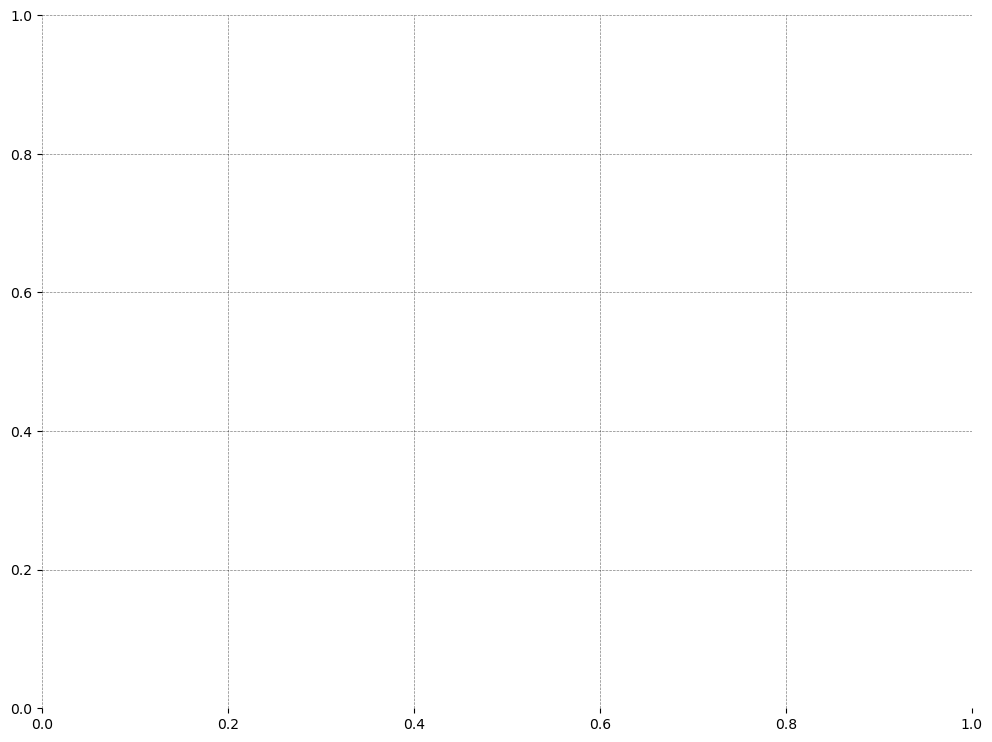

In [24]:
fig = plt.figure(figsize=(12, 9))
ax = plt.axes()
ax.grid(linewidth = 0.5, color = 'black', alpha = 0.5, linestyle = '--', zorder = 10)
ax.set_frame_on(False)
c = ax.pcolormesh(correlation.norm_radius, correlation.height, dataToPlot, vmin = -1, vmax = 1, cmap = cmap.tempAnoms3())
ax.set_title('Correlation between Normalized Wind and VMax\nAll TC-RADAR Swaths', fontweight = 'bold', loc = 'left')
ax.set_title('Deelan Jariwala', loc = 'right')
cbar = plt.colorbar(c, orientation='vertical', aspect=50, pad=0.02)
plt.savefig(r"C:\Users\deela\Downloads\tdrWindCorr.png", dpi = 400, bbox_inches = 'tight')
plt.show()

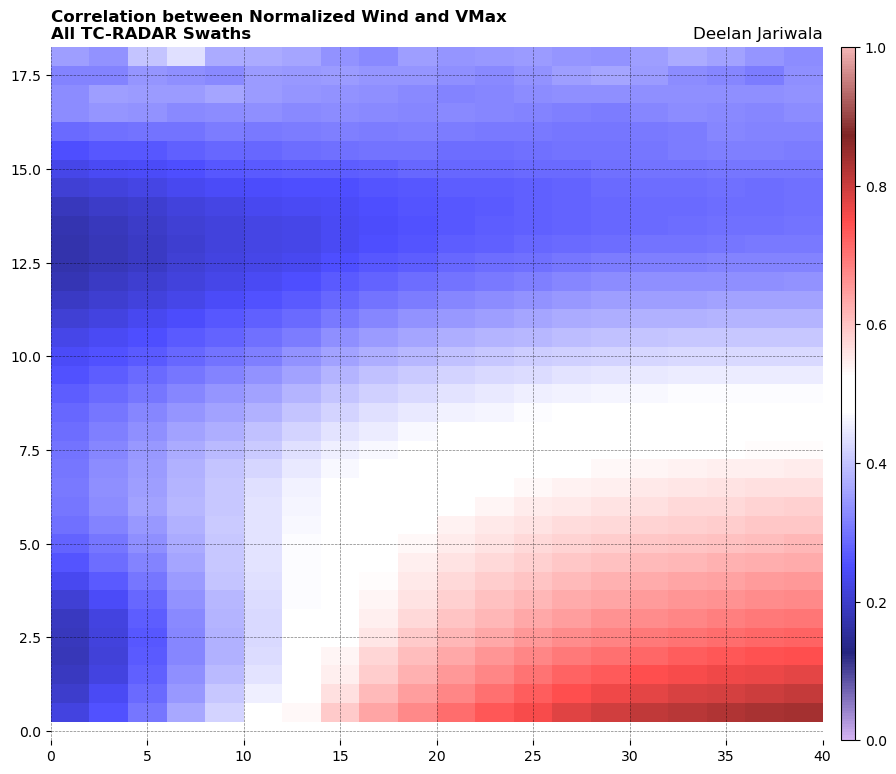

In [12]:
fig = plt.figure(figsize=(12, 9))
ax = plt.axes()
ax.grid(linewidth = 0.5, color = 'black', alpha = 0.5, linestyle = '--', zorder = 10)
ax.set_frame_on(False)
c = ax.pcolormesh(correlation.group_bins, correlation.height, normProfile.mean('num_cases'), vmin = 0, vmax = 1, cmap = cmap.tempAnoms3())
ax.set_title('Correlation between Normalized Wind and VMax\nAll TC-RADAR Swaths', fontweight = 'bold', loc = 'left')
ax.set_title('Deelan Jariwala', loc = 'right')
cbar = plt.colorbar(c, orientation='vertical', aspect=50, pad=0.02)
plt.savefig(r"C:\Users\deela\Downloads\tdrWindCorr.png", dpi = 400, bbox_inches = 'tight')
plt.show()